In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
import seaborn as sns

for i in range(2):
    matplotlib.rc('font', size=15)

task_names = ['Length', 'WordContent', 'Depth', 'TopConstituents', 'BigramShift', 'Tense', 'SubjNumber', 
              'ObjNumber', 'OddManOut', 'CoordinationInversion']
def get_task_type(task):
    if task in ['Length', 'WordContent']: return "surface"
    if task in ['Depth', 'TopConstituents', 'BigramShift']: return "syntactic"
    return "semantic"
task_type_codes = {"surface": 0, "syntactic": 1, "semantic": 2}
task_type_colours = [np.array(colors.to_rgb(c)) for c in ["seagreen", "teal", "steelblue"]]

def colour_to_bw(cl):
    if len(cl) == 3: return np.array([np.mean(cl), np.mean(cl), np.mean(cl)]) # rgb
    return np.array([np.mean(cl[:3]), np.mean(cl[:3]), np.mean(cl[:3]), cl[3]]) #rgba
def modify_cl(cl, modifier):
    cl = cl*modifier
    return np.array([max(0, min(c, 1.0)) for c in cl])

T = len(task_names)
strategies = ["single", "max", "avg"]
files = {
    "teacher_CoLA_L-1": {strategy: "teacher_CoLA_{}_-1.csv".format(strategy) for strategy in strategies},
    "teacher_SST-2_L-1": {strategy: "teacher_SST-2_single_-1.csv" for strategy in strategies},
}

single
Length 1.470000000000013 200 0.0
WordContent 0.0 50 0.0
Depth 0.8200000000000003 100 0.0
TopConstituents 1.8300000000000125 200 0.0
BigramShift 0.0799999999999983 50 0.1
Tense 0.3299999999999983 50 0.0
SubjNumber 0.710000000000008 200 0.1
ObjNumber 1.2600000000000051 200 0.1
OddManOut 0.44000000000001194 200 0.1
CoordinationInversion 1.5999999999999943 50 0.0
max
Length 4.140000000000001 200 0.0
WordContent 0.0 50 0.0
Depth 1.629999999999999 50 0.0
TopConstituents 2.5700000000000003 200 0.0
BigramShift -0.020000000000010232 50 0.1
Tense 0.3299999999999983 200 0.0
SubjNumber 0.7600000000000051 100 0.0
ObjNumber 0.8000000000000114 100 0.2
OddManOut 0.13000000000000966 100 0.0
CoordinationInversion 1.4299999999999926 100 0.0
avg
Length 3.0 200 0.0
WordContent 0.0 50 0.0
Depth 1.3800000000000026 200 0.0
TopConstituents 1.259999999999991 200 0.0
BigramShift 0.1600000000000108 50 0.1
Tense 0.39000000000000057 100 0.2
SubjNumber 0.6400000000000006 200 0.1
ObjNumber 1.230000000000004 50

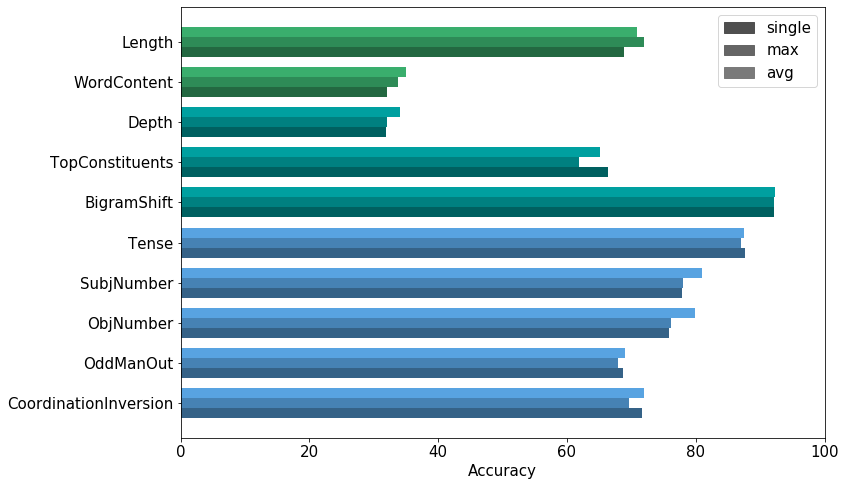

In [5]:
group = "teacher_CoLA_L-1"
vals_to_plot = {strategy: [] for strategy in strategies}

for strategy in strategies:
    print(strategy)
    data = pd.read_csv("probing/{}".format(files[group][strategy]))
    for task_name in task_names:
        rows = data[data["task"] == task_name]
        best_row = rows.loc[rows["devacc"].idxmax()]
        print(task_name, rows.loc[rows["devacc"].idxmax()]["acc"] - rows.loc[rows["devacc"].idxmin()]["acc"], best_row["nhid"], best_row["dropout"])
        vals_to_plot[strategy].append(best_row["acc"])
fig = plt.figure(figsize=(12, 7))
ax = plt.gca()
w = 1.2
for i, strategy in enumerate(strategies):
    ys = np.arange(0, T*4*w, w*4) + i*w
    colour_modifier = 1 + (i - 1)/4
    colours = [modify_cl(task_type_colours[task_type_codes[get_task_type(task)]], colour_modifier) for task in task_names]
    ax.barh(ys, vals_to_plot[strategy][::-1], height=w, align="edge", label=strategy, color=colours[::-1])
ax.set_yticks(np.arange(0, T*4*w, w*4) + 3*w/2)
ax.set_yticklabels(task_names[::-1])
ax.set_xlabel("Accuracy")
ax.set_xlim(left=0, right=100)
plt.legend()
leg = ax.get_legend()
cl = colour_to_bw(np.mean(task_type_colours, axis=0))
for i, (lh, s) in enumerate(zip(leg.legendHandles, strategies)):
    colour_modifier = 1 + (i - 1)/4.7
    lh.set_color(cl*colour_modifier)
fig.tight_layout()
plt.show()
fig.savefig("img/probing_{}.png".format(group))